### bigplanet Example

David Fleming, July 2016

---

In this notebook, I'll run through the basic functionality of bigplanet, a package for data-processing, analysis, and plotting of data produced by VPLANET.


In [1]:
#Imports
%matplotlib inline

from __future__ import print_function, division, absolute_import

#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['font.size'] = 20.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
mpl.rc('text', usetex=True)

# 0) Import bigplanet

---

bigplanet, a dumb wordplay on ``big data`` and ``VPLANET``, is a suite of tools used to wrangle and analyze data produced by large-scale ``VPLANET`` simulation suites.  It is currently under active development and any/all suggestions, bug discoveries, pull requests, etc are very much appreciated!

bigplanet can be imported and used just like any other python module.

In [2]:
from bigplanet import data_extraction as de
from bigplanet import bigplot as bp

# 1) Load in Data

---

Let's say we ran a simulation where we varied several body parameters in some grid over parameters such as binary semimajor axis, eccentricity and the same for a circumbinary planet (CBP).  The suite of simulations, set up using ``vspace``, produced a lot of directories, one for each simulation, so in order to work with the data products, we need to traverse through each directory, extract the results, and transform them into a meaningful data structure.  

Currently, ``bigplanet`` supports extracting data into a python list of dicts or into a hdf5 dataset.  The former is useful for small suites of simulations that can all fit into memory and is pretty fast.  The latter is a versitile compressed file format that allows for quick access of data that cannot fit into memory.  The hdf5 format stores array-like data in a unix-like filetree system that supports random-access by decompressing the given data in real-time.  It's only a factor of a few slower than the all-into-memory approach so I'll default to that for this demo.

For more info on all things hdf5, check out these links:

hdf5 with python: http://docs.h5py.org/en/latest/quick.html

hdf5 general: https://en.wikipedia.org/wiki/Hierarchical_Data_Format (the h, d, and f from hdf5!)

hdf5 group: https://www.hdfgroup.org/HDF5/

** Tell bigplanet where the data is **

---

Here, we'll load the data into the variable data.  When using the hdf5 format, data is actually an object that stores metadata about the hdf5 dataset for ease of manipulation.  For this, we must make known the source directory, src, the location of the hdf5 dataset, dataset, and the format we'll be using, fmt.

In [3]:
# Path to the root directory where all the simulation subdirectories live
src = "/Users/dflemin3/Desktop/GM_run/"

# Define names for archive (for python dict approach not used here)
archiveName = src + "GM_suite.npz"

# Define name for the dataset (hdf5 approach)
dataset = src + "simulation.hdf5"

# Define a data format
fmt = "hdf5"

** Load in the data!**

---

Here we actually get a data object to manipulate and work with.  This bit of code discriminates between the two formats and prints out useful information.  I should make this into a function.  The core of this "function" occurs in the following line
>    data = de.extract_data_hdf5(src=src, dataset=dataset)

We pass the extract_data_hdf5 function the source directory src and the name of the dataset, dataset.  If the dataset does not exist, i.e. all the data directories in source have not been traversed and parsed, then the function will traverse the simulation directories and store the data into dataset.  On my slow laptop, this takes ~1.5 minutes for ~1000 simulations.  If dataset does exist, it's quickly loaded into data.

In [4]:
if fmt == "dict":
    if (not os.path.exists(archiveName)):
        data = de.extract_data(src)

        print("Creating archive:",archiveName)
        np.savez(archiveName,data=data)
    # Archive exists, load it
    else:
        print("Loading existing archive:",archiveName)
        data = np.load(archiveName)["data"]
elif fmt == "hdf5":
    data = de.extract_data_hdf5(src=src, dataset=dataset, order="grid",compression="gzip")
    print(data)
else:
    print("Invalid format:",fmt)
    data = None

Hdf5 dataset already exists.  Reading from: /Users/dflemin3/Desktop/GM_run/simulation.hdf5
Name: /Users/dflemin3/Desktop/GM_run/simulation.hdf5. Size: 625. Order: grid


In [17]:
data.sim_name(-1)

'GM_simbe4_ba4_cfe4_ca4'

# 2) Data Processing

---

The real power of this package is the easy of data access and manipulation.  In this section, I'll show the user how to access the results of ``VPLANET`` simulations in a variety of ways.

**Individual simulation data**

---

Suppose you want to pull the binary (stored in the body "secondary") orbital eccentricity and the simulation time from the 2nd (index 1) simulation to plot how it varies as a function of time.  Accessing it is as easy as the following:

In [5]:
time, ecc = data.get(1,"secondary",["Time","Eccentricity"])
print("Time:",time[0:10],"...")
print("Ecc:",ecc[0:10],"...")

Time: [       0.  1000000.  2000000.  3000000.  4000000.  5000000.  6000000.
  7000000.  8000000.  9000000.] ...
Ecc: [ 0.01      0.008694  0.007955  0.007777  0.007695  0.007647  0.007616
  0.007595  0.00758   0.007569] ...


In [6]:
de.data_from_dir_hdf5?

The get method for the data object takes the following arguments:
```
1) Simulation number : int
2) body name : str
3) parameter or list of parameters : str, list of str
```

This method allows for easy data access for individual simulations and allows for one to iterate over an arbitrary number of simulations.  This is useful if, for whatever reason, the user would want to plot binary eccentricity as a function of time from every simulation.

### Documentation Notes

---

Note that by typing

>some_bigplanet_func.?

into an ipython cell, the docs will appear allowing the user to see what the function does, its input parameters, what they are, what the function returns, etc.  I've taken a lot of time to write out the docs so that the function's arguments and purpose are more clear.  Also, the user can also open up the source file to read further documentation that breaks down what each part of the function is doing.  Alternatively, you can always bug me (David) for an explanation, or to see if even I remember what I wrote.

**Bulk Simulation Results**

What if we don't want data from individual simulations, but rather some matrix-like structure that shows how one or many parameter changes as a function of initial simulation conditions.  For example, what if one wants to see how the CBP eccentricity at some given time varies as a function of binary a, e and CBP e. 

To do this, we'll use another function, aggregate_data, that uses the following calling sequence:
>de.aggregate_data(data, bodies=bodies, ind=0, funcs={"cbp" : {"Semim" : np.mean}},
>                    new_cols=new_cols,cache="cache.pkl",fmt=fmt,**kw)


Instead of actually producing a matrix, this function produces a dictionary of pandas dataframes where the key is the body name and the value is a pandas dataframe where the columns are the parameters varied over the simulation for the given body and any other user-defined columns (I'll discuss this later).

This function can get as complex as the user wants it to get, so we'll break it down by input parameter:

---

1) data
``` 
hdf5 dataset object
``` 
2) bodies
```
dictionary where the keys are body names and and the values are lists of the initial parameters that were varied for said object.  In our typical example, binary eccentricity was varied in the vspace input file with some line like
    secondary.in
    dEcc [0.01,0.1,n5] dEcc
    
In the secondary.in file, eccentricity is outputted by specifying "Eccentricity" in the saOutputOrder line.
Hence to have that parameter in the final matrix, we would need to include in the bodies dict

"secondary" : ['Eccentricity']

amongst other parameters of interest.  In the cell below our simulation grid spanned binary a, e and the same for the cbp and our bodies dict reflects that.
```

3) ind
```
Time index to extract for the given body's variable from each simulation, e.g. the binary's initial (time[ind = 0]) eccentricity.
This makes it explicit that we want the matrix to span initial simulation conditions.  I'm not sure why/if a user would have their grid over other time, but this variable allows for that functionality.
```

4) funcs
```
Funcs is a nested dictionary of the form {body : {body_variable : function}, body2 : {...}, ...}.  If something in funcs is specified for the variable of a given body, the funcs functionality supercedes the ind behavior and stores the result of funcs of that variable time series instead of the initial condition.  

In the example below, I use funcs to store the mean CBP semimajor axis instead of the initial condition.  Typically a user won't use this, but it could be useful.
```

5) new_cols
```
New_cols is another nest dictionary that is rather powerful and allows the user to apply any function to the simulation data to produce a new data product for each simulation.  The effect of this is to add another column to the final dataframe.

In the example below, I want to add the initial eccentricity again for a trivial example.

new_cols = {"cbp" : {"InitEcc" : trivial}}

This tells aggregate_data that for the cbp body, I want a new column, "InitEcc", added and it's computed by the trivial function.  Obviously, this functionality becomes useful for non-trivial calculations like computing eccentricity damping times for the cbp.

Note that any functions supplied to new_cols require the first 3 parameters to be

data, sim, body

and require a fmt kwarg. See the docs for more details.
```

6) kw
```
A dictionary of any keyword arguments the functions in new_cols require.
```

7) cache
```
Where to cache the output of this function into a pickle file.  This is useful if any of your new_cols functions are computationaly expensive and the pickle file can be transfered and read by all sorts of machines and python distros.
```

8) fmt
```
Tells the function whether you are using the dict or hdf5 data format.
```

**Example**

---

Ok, that's a lot of information, so let's see it in action.  To show off functionality, below I wrote a trivial function that returns the initial eccentricity and takes a keyword argument.

In [7]:
# Trivial function to return initial eccentricity
# This function assumes an hdf5 format
def trivial(data,sim,body,key=None,fmt="hdf5"):
    # Check out the get function in action!
    return data.get(sim,body,key)[0]

In [8]:
# Define the bodies and body variables to extract using a dictionary
bodies = {'cbp': ['Eccentricity', 'SemimajorAxis'],'secondary': ['SemimajorAxis','Eccentricity']}

# Define the new value (dataframe column) to produce for a given body.  The new column
# and how to calculate it are given as a dictionary for each body.

# New column for the cbp is "InitEcc" and is calculated using the function "trivial"
new_cols = {"cbp" : {"InitEcc" : trivial}}

# Define any keyword arguments trivial might need
kw = {"key" : "Eccentricity"}

# Extract and save into a cache (or read from it if it already exists)
# Note ind=0 makes it clear that we want initial conditions stored for all non-new_cols variables
df = de.aggregate_data(data, bodies=bodies, ind=0, funcs={"cbp" : {"SemimajorAxis" : np.mean}},
                    new_cols=new_cols,cache=src+"trivial_cache.pkl",fmt=fmt,**kw)

Reading data from cache: /Users/dflemin3/Desktop/GM_run/trivial_cache.pkl


** What does df look like?**

In [9]:
# CBP dataframe with new column produced by user-defined function!
df["cbp"].head(5)

,Eccentricity,InitEcc,SemimajorAxis
0,0.038669,0.038669,0.498178
1,0.038107,0.038107,0.672144
2,0.037851,0.037851,0.846260
3,0.037713,0.037713,1.020163
4,0.037632,0.037632,1.194305


In [10]:
# Same, but for secondary
df["secondary"].head(5)

,Eccentricity,SemimajorAxis
0,0.01,0.05
1,0.01,0.05
2,0.01,0.05
3,0.01,0.05
4,0.01,0.05


# 3) Plotting

---

Now let's use the dataframe df we created in the section about to generate a summary plot for our simulation suite.  With any large, high-dimensional simulation suite, we'll vary over more parameters than we can neatly plot in a single figure.  Instead of making a confusogram, we'll plot some variable as a function of 2 initial coniditions and marginalize over all other dimensions.  For example, if we want to see how initial CBP eccentricity varies as a function of binary semimajor axis and eccentricity, we'll need to average over other dimensions.  Naturally when marginalizing over other dimensions, the user should ensure that he/she are not losing information in the process.  Below I'll show off two functions that produce the marginalized plots using either matplotlib's imshow or contourf.

** Shape **

Before I get into the plotting functions, I want to introduce the concept of the simulation suite's shape.  In this small test suite, I used vspace to vary binary eccentricity, semimajor axis and the same for the planet in 5 steps.  See the below vspace input file.

In [11]:
! cat /Users/dflemin3/Desktop/GM_run/input

srcfolder  /usr/lusers/dflemin3/bin/vplanet/examples/binary_hyak
destfolder /gscratch/stf/dflemin3/vplanet_sims/GM_test
trialname  GM_sim

file   primary.in

file   secondary.in
dEcc  [0.01,0.3,n5] be
dSemi [0.05,0.2,n5] ba

file cbp.in
dFreeEcc [0.05,0.3,n5] cfe
dSemi [0.5,1.2,n5] ca

file   vpl.in


From inspection, we can see that the shape of this dataset is 5 x 5 x 5 x 5.  When using functions that marginalize over other dimensions, the shape must be specified as an interable so the function knows how to compress the data.

** Dims **

Similar to shape, the dimensions over which we must marginalize must be known to the function.  This allows the function to know exactly what it must marginalize over.  Dims defaults to -1 (marginalize over the last dimension) but in general is an iterable.

** Can we plot yet?**

Almost.  To use the function, we need to specify a few things.  First, we need x, y and the color variable z.  These are accessed from the dataframe df.  Next, we specify the shape in the manner described above.  Then, we create a figure and axis, if we haven't already, for the plot to live on.  Finally, we have the option of passing the axis labels.  Then plot!

** Imshow with Gaussian Interpolation **

NameError: name 'bp' is not defined

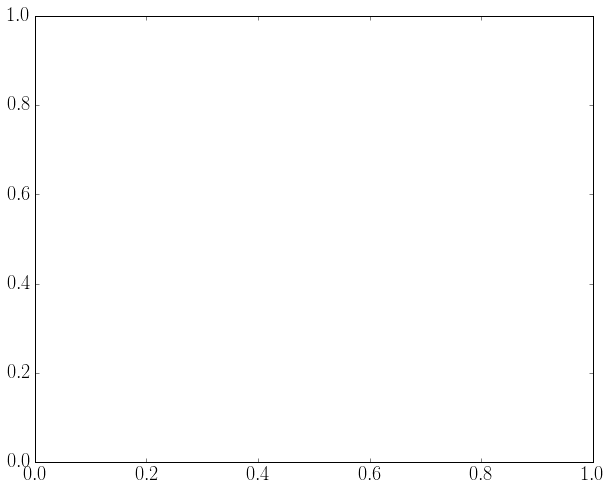

In [12]:
# Init axes labels, data to plot
labels = ["Binary Semimajor Axis [AU]", "Binary Eccentricity", "Initial CBP Eccentricty"]
x = df["secondary"]["SemimajorAxis"]
y = df["secondary"]["Eccentricity"]
z = df["cbp"]["InitEcc"]

# Shape of the data
shape = (5, 5, 5, 5)

# Dimensions to compress over
dims = (-2, -1)

fig, ax = plt.subplots()

bp.plot_red_dim(x, y, z, shape, fig, ax, dims=dims, labels=labels)

** Contour plot with user-defined number of contours (levels) **

In [ ]:
# Init axes labels, data to plot
labels = ["Binary Semimajor Axis [AU]", "Binary Eccentricity", "Initial CBP Eccentricty"]
x = df["secondary"]["SemimajorAxis"]
y = df["secondary"]["Eccentricity"]
z = df["cbp"]["Eccentricity"]

# Shape of the data
shape = (5, 5, 5, 5)

# Dimensions to compress over
dims = (-2, -1)

# Number of levels for a contour plot
levels = 15

fig, ax = plt.subplots()

bp.plot_red_dim_contour(x, y, z, shape, fig, ax, dims=dims, labels=labels, levels=levels)